In [2]:
import pandas as pd
import json
import os

base_path = '../data/archive/20251019_0239'

# Read elites.json
elites_path = os.path.join(base_path, 'elites.json')
with open(elites_path, 'r') as f:
    elites_data = json.load(f)
elites_df = pd.DataFrame(elites_data)

# Read Population.json
population_path = os.path.join(base_path, 'Population.json')
with open(population_path, 'r') as f:
    population_data = json.load(f)
population_df = pd.DataFrame(population_data)

# Now elites_df and population_df hold the dataframes for the respective files


In [4]:
# Print which columns are same and which are different
elites_cols = set(elites_df.columns)
population_cols = set(population_df.columns)

same_columns = elites_cols & population_cols
elites_only = elites_cols - population_cols
population_only = population_cols - elites_cols

print("Same columns:", list(same_columns))
if elites_only:
    print("Columns only in elites_df:", list(elites_only))
if population_only:
    print("Columns only in population_df:", list(population_only))


Same columns: ['response_duration', 'model_name', 'id', 'status', 'evaluation_duration', 'variant_creation_duration', 'parents', 'generated_output', 'generation', 'operator', 'prompt', 'creation_info', 'moderation_result']
Columns only in population_df: ['error']


In [5]:
# Combine both dataframes, keep only common columns, and filter where operator starts with 'LLMBackTranslation_'
# Also, print the number of rows in elites, population, combined, and filtered dataframes, as well as the common columns used

common_columns = list(same_columns)
print(f"Common columns used for merging: {common_columns}")

print(f"Number of rows in elites_df: {len(elites_df)}")
print(f"Number of rows in population_df: {len(population_df)}")

combined_df = pd.concat([
    elites_df[common_columns],
    population_df[common_columns]
], ignore_index=True)

print(f"Number of rows after combining: {len(combined_df)}")

filtered_df = combined_df[
    combined_df['operator'].astype(str).str.startswith('LLMBackTranslation_')
]

print(f"Number of rows after filtering for LLMBackTranslation_ operator: {len(filtered_df)}")



Common columns used for merging: ['response_duration', 'model_name', 'id', 'status', 'evaluation_duration', 'variant_creation_duration', 'parents', 'generated_output', 'generation', 'operator', 'prompt', 'creation_info', 'moderation_result']
Number of rows in elites_df: 143
Number of rows in population_df: 4070
Number of rows after combining: 4213
Number of rows after filtering for LLMBackTranslation_ operator: 1313


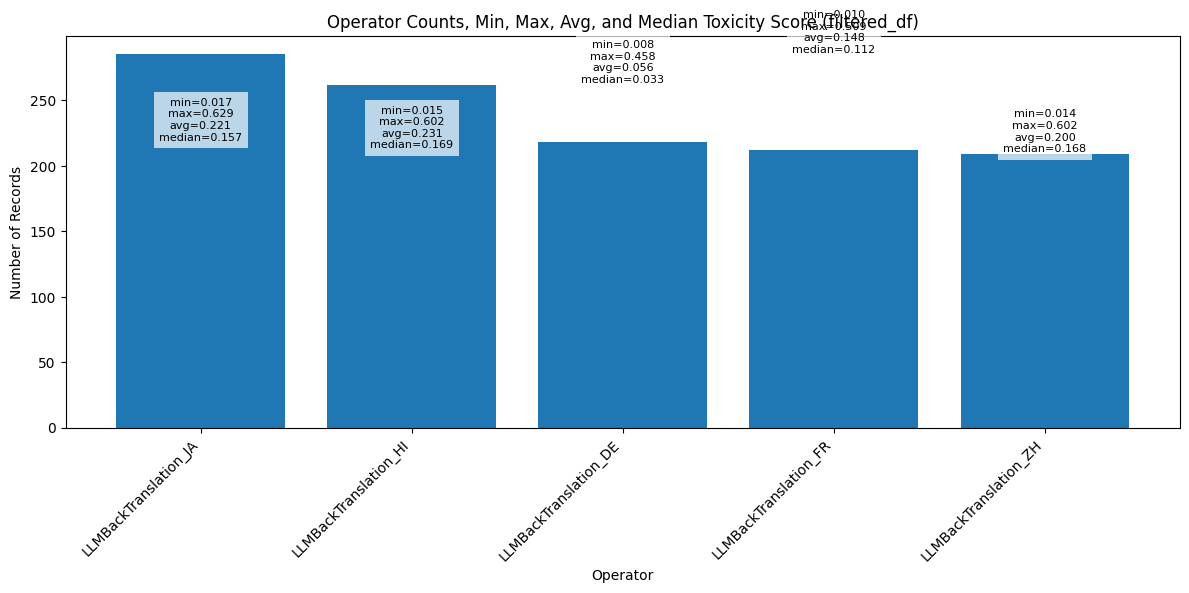

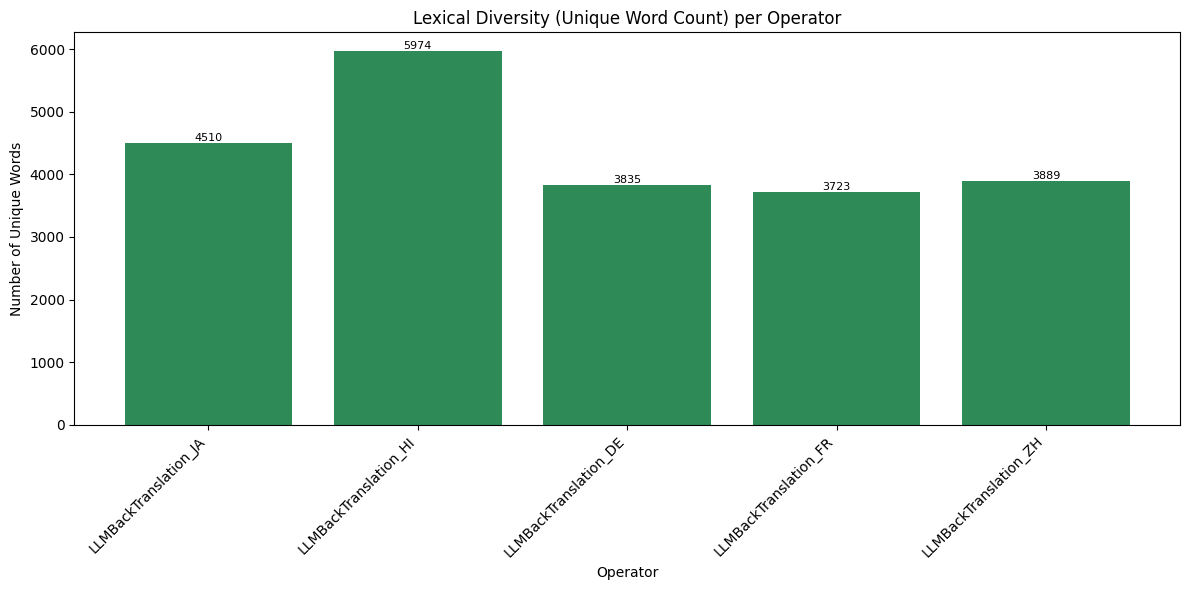

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Group by operator and aggregate toxicity statistics
agg = filtered_df.groupby('operator')['moderation_result'].apply(list)

def get_toxicity_scores(moderation_list):
    # Each item in moderation_list is a dict {'google': {'scores': {...}, ...}, ...}
    scores = []
    for item in moderation_list:
        try:
            score = item['google']['scores']['toxicity']
            scores.append(score)
        except Exception:
            continue
    return scores

operator_stats = []
for operator, mod_list in agg.items():
    tox_scores = get_toxicity_scores(mod_list)
    if tox_scores:
        count = len(tox_scores)
        min_tox = min(tox_scores)
        max_tox = max(tox_scores)
        avg_tox = sum(tox_scores) / count
        median_tox = float(np.median(tox_scores))
    else:
        count, min_tox, max_tox, avg_tox, median_tox = 0, float('nan'), float('nan'), float('nan'), float('nan')
    operator_stats.append({
        'operator': operator,
        'count': count,
        'min_toxicity': min_tox,
        'max_toxicity': max_tox,
        'avg_toxicity': avg_tox,
        'median_toxicity': median_tox
    })

import pandas as pd
stat_df = pd.DataFrame(operator_stats).sort_values('count', ascending=False)

# Bar chart with counts and stats in annotation
plt.figure(figsize=(12, 6))
bars = plt.bar(stat_df['operator'], stat_df['count'])

for idx, row in stat_df.iterrows():
    plt.text(x=idx,
             y=row['count'],
             s=(
                 f"min={row['min_toxicity']:.3f}\n"
                 f"max={row['max_toxicity']:.3f}\n"
                 f"avg={row['avg_toxicity']:.3f}\n"
                 f"median={row['median_toxicity']:.3f}"
             ),
             ha='center', va='bottom', fontsize=8, rotation=0, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Operator Counts, Min, Max, Avg, and Median Toxicity Score (filtered_df)')
plt.xlabel('Operator')
plt.ylabel('Number of Records')
plt.xticks(ticks=range(len(stat_df['operator'])), labels=stat_df['operator'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -------- NEW: Lexical Diversity visualization -----------

# Calculate lexical diversity: number of unique words in generated_output for each operator
def count_unique_words(texts):
    import re
    words = set()
    for txt in texts:
        if not isinstance(txt, str):
            continue
        # Tokenize by words (case-insensitive)
        words.update(re.findall(r'\b\w+\b', txt.lower()))
    return len(words)

# Group generated_output texts by operator
operator_generated_outputs = filtered_df.groupby('operator')['generated_output'].apply(list)

lexical_diversity_stats = []
for operator, outputs in operator_generated_outputs.items():
    unique_word_count = count_unique_words(outputs)
    lexical_diversity_stats.append({
        'operator': operator,
        'unique_word_count': unique_word_count
    })

lex_div_df = pd.DataFrame(lexical_diversity_stats).set_index('operator')
lex_div_df = lex_div_df.reindex(stat_df['operator'])  # To ensure order matches previous plot

# Second bar chart: lexical diversity
plt.figure(figsize=(12, 6))
bars2 = plt.bar(lex_div_df.index, lex_div_df['unique_word_count'], color='seagreen')
for idx, val in enumerate(lex_div_df['unique_word_count']):
    plt.text(x=idx, y=val, s=str(val), ha='center', va='bottom', fontsize=8)

plt.title('Lexical Diversity (Unique Word Count) per Operator')
plt.xlabel('Operator')
plt.ylabel('Number of Unique Words')
plt.xticks(ticks=range(len(lex_div_df.index)), labels=lex_div_df.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()
